Dimer with Kanamori interaction
=======

We calculate the Green function of a dimer coupled with Kanamori interaction and a coupling to discrete bath states.

The non-interacting hamiltonian is most conveniently expressed using a matrix representation

$$
\hat{h} =
\begin{pmatrix}
\hat{h}_{0} & \hat{h}_{\rm coup} \\
\hat{h}_{\rm coup} & \hat{h}_{\rm bath}  \\
\end{pmatrix}=
\begin{pmatrix}
\begin{pmatrix}
-\mu & 0 \\
0 & -mu
\end{pmatrix} & 
\begin{pmatrix}
t & 0 \\
0 & t
\end{pmatrix}
\\
\begin{pmatrix}
t & 0 \\
0 & t
\end{pmatrix} & 
\begin{pmatrix}
\epsilon_{00} & \epsilon_{01} \\
\epsilon_{10} & \epsilon_{11}
\end{pmatrix}
\end{pmatrix}
$$

The impurity interaction is of the Kanamori-type, and reads (impurity sites denoted by \{0,1\})

$$h_{\rm int} = \sum_{i,j=0}^{1} U n_{\uparrow,i} n_{\downarrow,j} + \sum_{\sigma,i\neq j} U' n_{\sigma,i} n_{\sigma,j}
            - \sum_{i \neq j} J c^\dagger_{i \uparrow} c_{i \downarrow} c^\dagger_{j \downarrow} c_{j \uparrow}
            + \sum_{i \neq j} J c^\dagger_{i \uparrow} c^\dagger_{i \downarrow} c_{j \downarrow} a_{j \uparrow}$$
   
The parameters are defined below.

In [1]:
# %load model.py
import sys, os
sys.path.append(os.getcwd() + '/../common')
from util import *

from pytriqs.gf import Gf, MeshImFreq, iOmega_n, inverse
from pytriqs.operators import c, c_dag, n
from pytriqs.operators.util.hamiltonians import h_int_kanamori
from itertools import product
from numpy import matrix, array

# ==== System Parameters ====
beta = 5.           # Inverse temperature
mu = 0.25           # Chemical potential
U = 1.              # Density-density interaction for opposite spins
Up = 0.3            # Density-density interaction for equal spins
J = 0.5             # Hunds coupling
t = 1.              # Hopping between impurity sites
epsilon = matrix([[0.2,0.1],[0.1,0.2]]) # Bath state energy

# ==== Local Hamiltonian ====
h_0 = - mu*( n('up',0) + n('dn',0) + n('up',1) + n('dn',1) ) \
      + t* ( c_dag('up',0) * c('up',1) + c_dag('up',1) * c('up',0) + \
             c_dag('dn',0) * c('dn',1) + c_dag('dn',1) * c('dn',0) )

h_int = h_int_kanamori(['up','dn'],[0,1],
                        array([[0,Up-3*J],[Up-3*J,0]]), # Interaction for equal spins
                        array([[U,U-2*J],[U-2*J,U]]),   # Interaction for opposite spins
                        J,True)

h_loc = h_0 + h_int

# ==== Bath & Coupling hamiltonian ====
h_bath, h_coup = 0, 0
for sig in ['up','dn']:
    h_coup += c_dag(sig,0) * c(sig,2) + c_dag(sig,2) * c(sig,0)
    h_coup += c_dag(sig,1) * c(sig,3) + c_dag(sig,3) * c(sig,1)
    h_bath += epsilon[0,0] * n(sig,2) + epsilon[1,1] * n(sig,3)
    h_bath += epsilon[0,1] * c_dag(sig,2) * c(sig,3) + epsilon[1,0] * c_dag(sig,3) * c(sig,2)

# ==== Total impurity hamiltonian and fundamental operators ====
h_imp = h_loc + h_coup + h_bath
fundamental_operators = [ c(spin,i) for spin, i in product(['up','dn'],range(4)) ]

# ==== Green function structure ====
gf_struct = [ ['up',[0,1]], ['dn',[0,1]] ]

# ==== Hybridization Function ====
n_iw = 10
iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
Delta = Gf_from_struct(mesh=iw_mesh, struct=gf_struct)
Delta << inverse(iOmega_n - epsilon);

# ==== Non-Interacting Impurity Green function  ====
G0_iw = Gf_from_struct(mesh=iw_mesh, struct=gf_struct)
G0_iw['up'] << inverse(iOmega_n + mu - t * matrix([[0,1],[1,0]]) - Delta['up']) # FIXME Should work for BlockGf
G0_iw['dn'] << inverse(iOmega_n + mu - t * matrix([[0,1],[1,0]]) - Delta['dn'])


Green Function G_dn with mesh Matsubara Freq Mesh of size 20, domain Matsubara domain with beta = 5, statistic = 1, positive_only : 0 and target_rank 2: 

Results
====

In [2]:
from pytriqs.plot.mpl_interface import oplot, plt
%matplotlib inline

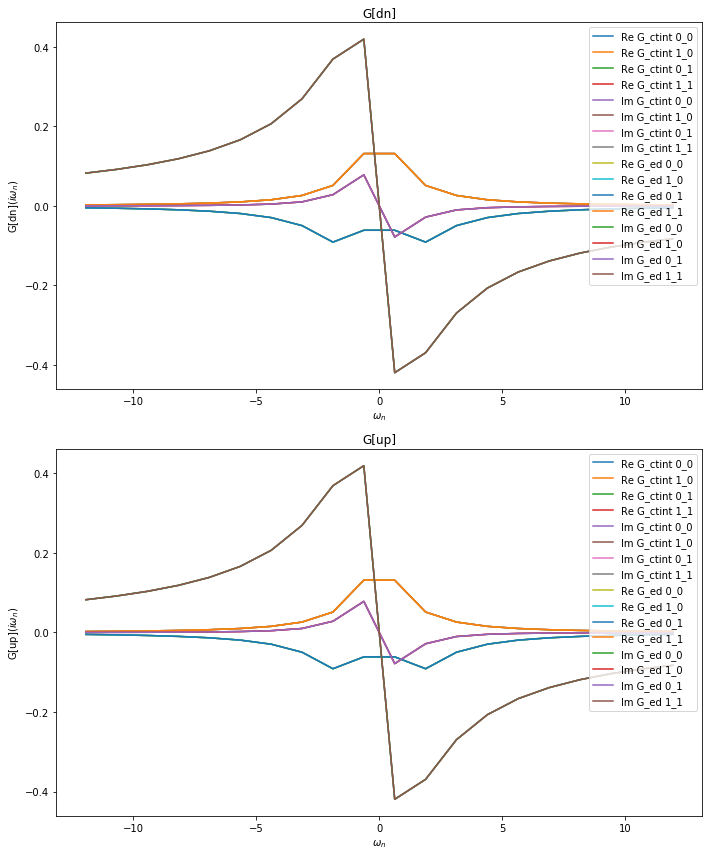

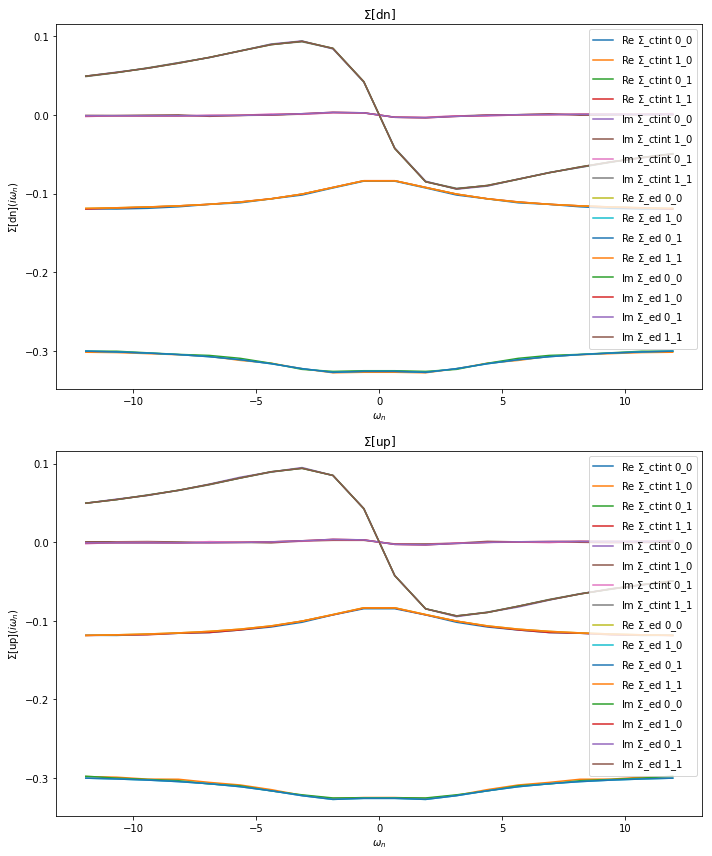

In [3]:
# %load ../common/plot.py
import sys, os
sys.path.append(os.getcwd() + "/..")
from model import *

from pytriqs.archive import HDFArchive
from pytriqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

# === Load Green function for every solver and calculate self-energy

solver_lst = [ basename(f).strip('.h5') for f in glob('results/*.h5') ]
G, Sigma = {}, {}

for solver in solver_lst:
    dat = HDFArchive('results/' + solver + '.h5','r')
    G[solver] = dat['G']
    Sigma[solver] = G0_iw.copy()
    Sigma[solver] << inverse(G0_iw) - inverse(G[solver])

# === For every block and solver, plot Green function and Self energy

block_lst = list(G[solver_lst[0]].indices)
n_blocks = len(block_lst)

for g, name in [[G, 'G'], [Sigma, '$\Sigma$']]:

    plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

    for i, block in enumerate(block_lst,1):
        fig = plt.subplot(n_blocks,1,i)
        fig.set_title(name + "[" + block + "]")
        for solver in solver_lst:
            oplot(g[solver][block], name = name + "_%s" % solver)
        plt.xlabel("$\omega_n$")
        plt.ylabel(name + "[" + block + "]$(i\omega_n)$")

    plt.tight_layout()
    plt.show()


Deviations
======

We present a table containing deviations between the different solvers measured via

$$||G_{\rm Solver_1} - G_{\rm Solver_2}||_\infty$$

In [4]:
import numpy as np

for block in block_lst:
    deviations = [[ np.amax(np.abs(G[s1][block].data - G[s2][block].data)) for s1 in solver_lst ] \
                    for s2 in solver_lst ]
    
    print "\t\t    Deviations for Block " + block
    print "\t\t -----------------------------------"

    row_format ="{:>15}" * (len(solver_lst) + 1)
    print row_format.format("", *solver_lst)
    row_format ="{:>15}" + "{:>15.2E}" * len(solver_lst)
    for solver, row in zip(solver_lst, deviations):
        print row_format.format(solver, *row)
        
    print "\n\n"

		    Deviations for Block dn
		 -----------------------------------
                         ctint             ed
          ctint       0.00E+00       2.39E-04
             ed       2.39E-04       0.00E+00



		    Deviations for Block up
		 -----------------------------------
                         ctint             ed
          ctint       0.00E+00       2.57E-04
             ed       2.57E-04       0.00E+00



